# Bayesian Phase Difference Estimation (BPDE) Algorithm for Calculating Numerical Energy Gradient

Link to the paper: <https://pubs.acs.org/doi/10.1021/acs.jpclett.2c02737>

The Bayesian Phase Difference Estimation (BPDE) algorithm [1,2] is a quantum algorithm for calculating the energy difference between two electronic states in a given Hamiltonian.

In this tutorial, we will explain how BPDE algorithm computes the energy difference based on [1].

Let's start by importing all the necessary libraries.

In [1]:
from typing import cast

import numpy as np

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

from classiq import *
from classiq.applications.chemistry import Molecule, MoleculeProblem
from classiq.qmod.quantum_function import QFunc
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
)

PAULI_DICT = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}

Next, let's define the target diatomic molecule and write out the Hamiltonian. Here, we specify the hydrogen molecule.

In [2]:
# define your molecule problem


def get_electronic_structure_problem(internuclear_distance: float) -> MoleculeProblem:
    molecule = Molecule(
        atoms=[("H", (0.0, 0.0, 0)), ("H", (0.0, 0.0, internuclear_distance))]
    )
    return MoleculeProblem(
        molecule=molecule,
        basis="sto3g",
        mapping="jordan_wigner",
        z2_symmetries=True,
        freeze_core=True,
    )


gs_problem = get_electronic_structure_problem(internuclear_distance=0.74)
operator = gs_problem.generate_hamiltonian()
print("Your Hamiltonian is", operator.show(), sep="\n")

Your Hamiltonian is
-1.042 * I
-0.790 * Z
+0.181 * X


Let's vary the interatomic distance and plot the potential energy surface. In the case of the hydrogen molecule, we can see that it is most stable around 0.74 Å.

  0%|          | 0/30 [00:00<?, ?it/s]

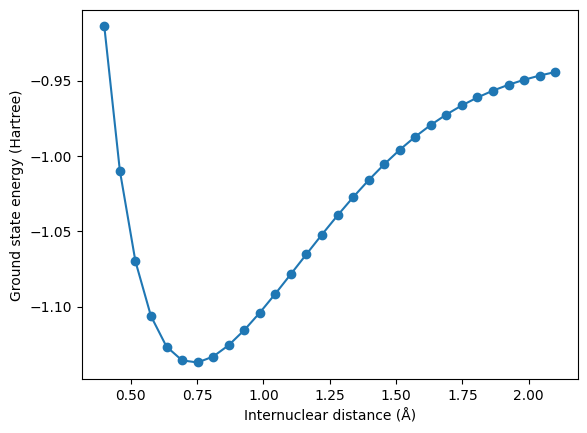

In [3]:
total_energies = []
distances = np.linspace(0.4, 2.1, 30)
for distance in tqdm(distances):
    problem = get_electronic_structure_problem(distance)
    operator = problem.generate_hamiltonian()
    mat = operator.to_matrix()
    w, v = np.linalg.eig(mat)
    result = np.real(min(w))
    result += 1 / (distance * 1.889726)  # Nuclear repulsion energy
    total_energies.append(result)

plt.plot(distances, total_energies, "o-")
plt.xlabel("Internuclear distance (Å)")
plt.ylabel("Ground state energy (Hartree)")
plt.show()

Let's visualize the gradient $dE/dr$ using the calculated energy.

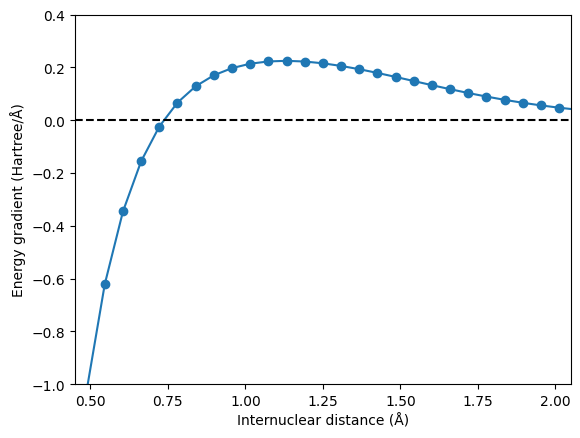

In [4]:
dr = distances[1] - distances[0]
distances_between = (np.array(distances) + dr / 2)[:-1]
total_energy_gaps = [
    (total_energies[i + 1] - total_energies[i]) / dr
    for i in range(len(total_energies) - 1)
]
plt.plot(distances_between, total_energy_gaps, "o-")
plt.hlines(0, 0.45, 2.05, linestyles="dashed", colors="k")
plt.xlim(0.45, 2.05)
plt.ylim(-1.0, 0.4)
plt.xticks(np.arange(0.5, 2.1, 0.25))
plt.xlabel("Internuclear distance (Å)")
plt.ylabel("Energy gradient (Hartree/Å)")
plt.show()

## Bayesian Phase Difference Estimation (BPDE) Algorithm for Numerical Energy Gradient Calculations  

Next, we explain how to calculate the energy gradient $dE/dR$ using the BPDE algorithm. In this algorithm, we construct the following circuit.

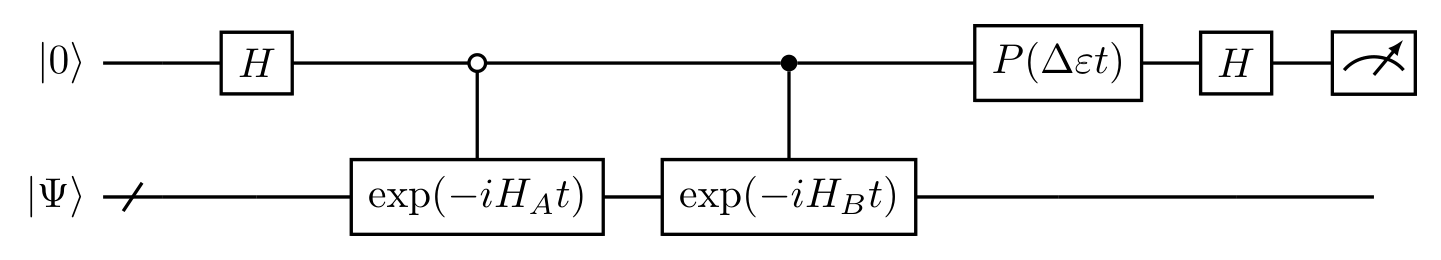

Let $|\Psi^{(A)}_0\rangle$ be the ground state of the Hamiltonian $H_A$, and $|\Psi^{(B)}_0\rangle$ be the ground state of the Hamiltonian $H_B$. Suppose after applying a Hadamard gate, the quantum state is given by  

$$
\frac{1}{\sqrt{2}} (|0\rangle \otimes |\Psi^{(A)}_0\rangle + |1\rangle \otimes |\Psi^{(B)}_0\rangle)
$$

In this case, the quantum state evolves as follows:  

$$
\begin{align*}
\frac{1}{\sqrt{2}} (|0\rangle \otimes |\Psi^{(A)}_0\rangle + |1\rangle \otimes |\Psi^{(B)}_0\rangle) &\xrightarrow{\text{controlled-}e^{-iH_At},\ \text{controlled-}e^{-iH_Bt}} \frac{1}{\sqrt{2}} (|0\rangle \otimes e^{-iE^{(A)}_0t}|\Psi^{(A)}_0\rangle + |1\rangle \otimes e^{-iE^{(B)}_0t}|\Psi^{(B)}_0\rangle) \\  
&\xrightarrow{P(\Delta\varepsilon t)} \frac{1}{\sqrt{2}} (e^{-iE^{(A)}_0t}|0\rangle \otimes |\Psi^{(A)}_0\rangle + e^{-i(E^{(B)}_0-\Delta\varepsilon)t}|1\rangle \otimes |\Psi^{(B)}_0\rangle) \\  
&\xrightarrow{H} \frac{1}{2} [(e^{-iE^{(A)}_0t} + e^{-i(E^{(B)}_0-\Delta\varepsilon)t}) |0\rangle \otimes |\Psi^{(A)}_0\rangle + (e^{-iE^{(A)}_0t} - e^{-i(E^{(B)}_0-\Delta\varepsilon)t}) |1\rangle \otimes |\Psi^{(B)}_0\rangle]  
\end{align*}
$$

At the measurement stage, the probability of measuring the zero state is  

$$
\text{Prob}(0) = \frac{1}{2} [1 + \cos\{(E^{(B)}_0 - E^{(A)}_0 - \Delta\varepsilon)t\}]
$$

which reaches its maximum when $\Delta\varepsilon = E^{(B)}_0 - E^{(A)}_0$.  

It is not necessary to input a perfect ground-state wavefunction. Any wavefunction $|\Psi\rangle$ can be expanded in terms of the eigenfunctions $|\Psi^{(A)}_j\rangle$ and $|\Psi^{(B)}_k\rangle$ of each Hamiltonian as follows:  

$$
|\Psi\rangle = \sum_j c_j |\Psi^{(A)}_j\rangle = \sum_k d_k |\Psi^{(B)}_k\rangle  
$$

Then, the probability of measuring the zero state is given by  

$$
\text{Prob}(0) = \frac{1}{2} \left[ 1 + \sum_{j,k} |c_j|^2|d_k|^2\cos\{(E^{(B)}_k - E^{(A)}_j - \Delta\varepsilon)t\} \right]
$$

If the overlap between the input wavefunction and the ground-state wavefunction is sufficiently large, the probability should reach its maximum when $ \Delta\varepsilon = E^{(B)}_0 - E^{(A)}_0 $, just as before.  

Here, we use the Hartree-Fock state for $|\Psi\rangle$.

If we take $H_B$ as the Hamiltonian of the hydrogen molecule at an interatomic distance of $R + \Delta r /2$ and $H_A$ as the Hamiltonian at $R - \Delta r /2$, we can determine the energy difference between the two ground states.  

Thus, using the finite difference method, the energy gradient $dE/dr$ can be approximated as  

$$
\frac{dE}{dr} \approx \frac{E(R + \Delta r /2) - E(R - \Delta r /2)}{\Delta r}
$$

In [5]:
def pauli_str_to_enums(pauli):
    return [PAULI_DICT[s] for s in pauli]


def pauli_list_to_hamiltonian(pauli_list):
    return [
        PauliTerm(
            pauli=pauli_str_to_enums(pauli), coefficient=cast(complex, coeff).real
        )
        for pauli, coeff in pauli_list
    ]


# Build the quantum circuit
def get_qfunc(
    molecule_problem_a: MoleculeProblem,
    molecule_problem_b: MoleculeProblem,
    delta_e: float,
    time: float,
    trotter_step_size: float = 0.5,
) -> QFunc:
    # Using the original pauli_list raises RecursionError, so we convert it
    pauli_list_a = molecule_problem_a.generate_hamiltonian().pauli_list
    hamiltonian_a = pauli_list_to_hamiltonian(pauli_list_a)
    pauli_list_b = molecule_problem_b.generate_hamiltonian().pauli_list
    hamiltonian_b = pauli_list_to_hamiltonian(pauli_list_b)

    @qfunc
    def main(readout: Output[QBit]):
        state = QArray("state")
        allocate(len(pauli_list_a[0][0]), state)
        allocate(1, readout)

        # Initialize the state to Hartree-Fock state
        molecule_hartree_fock(molecule_problem_to_qmod(molecule_problem_a), state)

        H(readout)
        X(readout)
        control(
            readout,
            lambda: suzuki_trotter(
                hamiltonian_a,
                evolution_coefficient=time,
                order=2,
                repetitions=int(np.ceil(time / trotter_step_size)),
                qbv=state,
            ),
        )
        X(readout)
        control(
            readout,
            lambda: suzuki_trotter(
                hamiltonian_b,
                evolution_coefficient=time,
                order=2,
                repetitions=int(np.ceil(time / trotter_step_size)),
                qbv=state,
            ),
        )
        PHASE(theta=delta_e * time, target=readout)
        H(readout)

    return main

In [6]:
# Test the quantum circuit

qmod = get_qfunc(
    molecule_problem_a=get_electronic_structure_problem(1.0),
    molecule_problem_b=get_electronic_structure_problem(1.0 + 0.0025),
    delta_e=0.1,
    time=1.0,
)
qmod = create_model(
    qmod,
    execution_preferences=ExecutionPreferences(
        backend_preferences=ClassiqBackendPreferences(
            backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
        )
    ),
    out_file="generated_files/test",
)
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/2vG2Eq3oupRVc5GdF8Mp6SKeFRi?login=True&version=0.74.0


In [7]:
result = execute(qprog).result_value()

In [8]:
result.parsed_state_vector

[SimulatedState(state={'readout': 0}, bitstring='00', amplitude=(-0.4608667065660602+0.8658488197838025j)),
 SimulatedState(state={'readout': 0}, bitstring='01', amplitude=(0.18819732059039795-0.009405273017554148j)),
 SimulatedState(state={'readout': 1}, bitstring='10', amplitude=(0.04243812563202298+0.02261040647871393j)),
 SimulatedState(state={'readout': 1}, bitstring='11', amplitude=(-0.0005703255060044571-0.009405273017554122j))]

Now let's verify that this quantum circuit can actually calculate the energy gradient.

In [9]:
def get_zero_state_measurement_prob(
    R: float, delta_r: float, time: float, delta_e: float
) -> float:
    qmod = get_qfunc(
        molecule_problem_a=get_electronic_structure_problem(R - delta_r / 2),
        molecule_problem_b=get_electronic_structure_problem(R + delta_r / 2),
        delta_e=delta_e,
        time=time,
    )
    qmod = create_model(
        qmod,
        execution_preferences=ExecutionPreferences(
            backend_preferences=ClassiqBackendPreferences(
                backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
            )
        ),
        out_file=f"generated_files/bpde_internuclear_distance_{R:.2f}_delta_r_{delta_r:.2f}_time_{time:.2f}_delta_e_{delta_e:.2f}",
    )
    qprog = synthesize(qmod)
    result = execute(qprog).result_value()
    probability = 0.0
    for parsed_state_vector in result.parsed_state_vector:
        if parsed_state_vector["readout"] == 0:
            probability += np.abs(parsed_state_vector.amplitude) ** 2

    return probability

  0%|          | 0/5 [00:00<?, ?it/s]

Max probability of measuring |0>: 0.999764393135571 at Δε = 0.00175


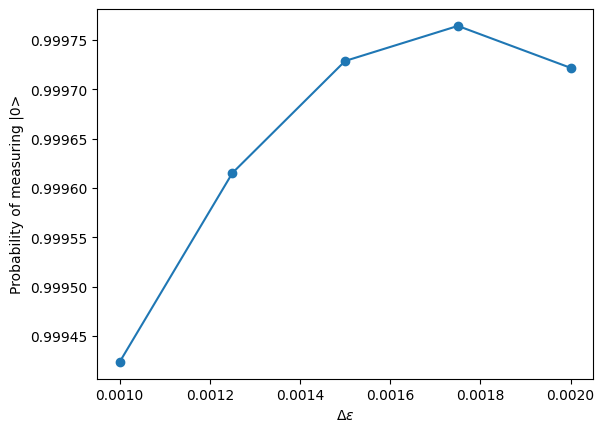

In [10]:
# Calculate the energy gradient by varying the Δε

# parameters
internuclear_distance = 1.0
time = 50.0
delta_r = 0.0025
delta_es = np.linspace(0.001, 0.002, 5)

# calculate the probability of measuring |0> for each delta_e
probs = [
    get_zero_state_measurement_prob(internuclear_distance, delta_r, time, delta_e)
    for delta_e in tqdm(delta_es)
]
print(
    "Max probability of measuring |0>:",
    max(probs),
    "at Δε =",
    delta_es[np.argmax(probs)],
)

# Plot the results
plt.plot(delta_es, probs, "o-")
plt.xlabel(r"$\Delta\varepsilon$")
plt.ylabel("Probability of measuring |0>")
plt.show()

Now, let's visualize the obtained gradient on the previously plotted energy gradient graph.

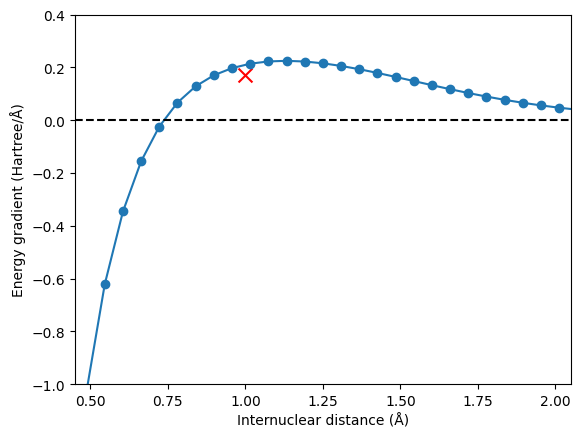

In [11]:
plt.plot(distances_between, total_energy_gaps, "o-")
plt.hlines(0, 0.45, 2.05, linestyles="dashed", colors="k")
# Add the energy gradient from the nuclear repulsion term
plt.scatter(
    [internuclear_distance],
    [delta_es[np.argmax(probs)] / delta_r - 1 / (internuclear_distance**2 * 1.889726)],
    marker="x",
    color="red",
    s=100,
)
plt.xlim(0.45, 2.05)
plt.ylim(-1.0, 0.4)
plt.xticks(np.arange(0.5, 2.1, 0.25))
plt.xlabel("Internuclear distance (Å)")
plt.ylabel("Energy gradient (Hartree/Å)")
plt.show()

From the above, we can see that when the probability of measuring the zero state is maximized, $\Delta\varepsilon / \Delta r \approx dE/dR$ holds.  

Here, note that the Coulomb repulsion between nuclei is not included in the Hamiltonian, so to obtain the complete energy gap, this Coulomb repulsion term must be added afterward.

Since measuring the probability for all $\Delta\varepsilon$ values is inefficient, we use Bayesian optimization to find the $\Delta\varepsilon$ that maximizes the probability.

In [12]:
# Define a prior distribution
# We will use a Gaussian distribution for the prior distribution
def gaussian(x, a, mu, sigma):
    return a * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


# Define the parameters for the Gaussian distribution
prior_a = 1.0  # amplitude of the Gaussian
prior_mu = 0.0  # mean of the prior distribution
prior_sigma = 1.0  # standard deviation of the prior distribution
popt = [prior_a, prior_mu, prior_sigma]
print(f"Initial guess: mu={prior_mu}, sigma={prior_sigma}")

# Define the parameters for the simulation
n_samples = 5  # number of samples to take for each iteration
# n_samples = 21  # the paper uses 21 samples, but it is too slow
init_time = 1.0
energy_threshold = 0.03  # threshold for convergence
delta_r = 0.0025
internuclear_distance = 1.0

# Initial samples
x_data = np.linspace(prior_mu - prior_sigma, prior_mu + prior_sigma, n_samples)
y_data = np.array(
    [
        get_zero_state_measurement_prob(
            internuclear_distance, delta_r, init_time, delta_e
        )
        for delta_e in x_data
    ]
)

# Maximum number of iterations
num_iterations = 30

for i in tqdm(range(num_iterations)):
    # Fit the obtained data to a Gaussian
    popt, _ = curve_fit(gaussian, x_data, y_data, p0=[1.0, prior_mu, prior_sigma])

    a_fit, mu_fit, sigma_fit = popt

    # Obtain the posterior distribution
    posterior_mu = (prior_mu / prior_sigma**2 + mu_fit / sigma_fit**2) / (
        1 / prior_sigma**2 + 1 / sigma_fit**2
    )
    posterior_sigma = np.sqrt(1 / (1 / prior_sigma**2 + 1 / sigma_fit**2))
    print(
        f"Iteration {i + 1}, Posterior mu: {posterior_mu:.5f}, Posterior sigma: {posterior_sigma:.5f}"
    )
    if posterior_sigma < energy_threshold:
        print("Convergence achieved.")
        break

    # Decide the next sampling points
    init_time = 1.8 / posterior_sigma  # this condition was derived empirically
    prior_mu = posterior_mu
    prior_sigma = posterior_sigma
    x_data = np.linspace(prior_mu - prior_sigma, prior_mu + prior_sigma, n_samples)
    y_data = np.array(
        [
            get_zero_state_measurement_prob(
                internuclear_distance, delta_r, init_time, delta_e
            )
            for delta_e in x_data
        ]
    )

print(f"Estimated optimal value: mu={posterior_mu:.5f}, sigma={posterior_sigma:.5f}")

Initial guess: mu=0.0, sigma=1.0


  0%|          | 0/30 [00:00<?, ?it/s]

Iteration 1, Posterior mu: 0.00069, Posterior sigma: 0.80997
Iteration 2, Posterior mu: 0.00146, Posterior sigma: 0.47574
Iteration 3, Posterior mu: 0.00161, Posterior sigma: 0.27942
Iteration 4, Posterior mu: 0.00172, Posterior sigma: 0.16412
Iteration 5, Posterior mu: 0.00173, Posterior sigma: 0.09640
Iteration 6, Posterior mu: 0.00174, Posterior sigma: 0.05662
Iteration 7, Posterior mu: 0.00173, Posterior sigma: 0.03326
Iteration 8, Posterior mu: 0.00173, Posterior sigma: 0.01954
Convergence achieved.
Estimated optimal value: mu=0.00173, sigma=0.01954


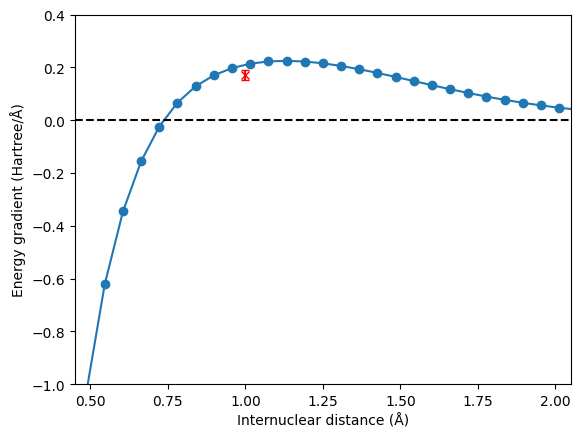

In [13]:
plt.plot(distances_between, total_energy_gaps, "o-")
plt.hlines(0, 0.45, 2.05, linestyles="dashed", colors="k")
# Add the energy gradient from the nuclear repulsion term
plt.errorbar(
    [internuclear_distance],
    [delta_es[np.argmax(probs)] / delta_r - 1 / (internuclear_distance**2 * 1.889726)],
    yerr=[
        posterior_sigma
    ],  # errorbar is the standard deviation of the posterior distribution
    marker="x",
    color="red",
    capsize=3,
)
plt.xlim(0.45, 2.05)
plt.ylim(-1.0, 0.4)
plt.xticks(np.arange(0.5, 2.1, 0.25))
plt.xlabel("Internuclear distance (Å)")
plt.ylabel("Energy gradient (Hartree/Å)")
plt.show()

## References

[1] K. Sugisaki, H. Wakimoto, K. Toyota, K. Sato, D. Shiomi, and T. Takui, Quantum Algorithm for Numerical Energy Gradient Calculations at the Full Configuration Interaction Level of Theory, J. Phys. Chem. Lett. 13, 11105 (2022).

[2] N. Wiebe and C. Granade, Efficient Bayesian Phase Estimation, Phys. Rev. Lett. 117, 010503 (2016).  

